# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
#<a href=http://www.ramp.studio>RAMP</a> on sea ice prediction

<i> Balázs Kégl (CNRS), Camille Marini (CNRS), Andy Rhines (UW), Jennifer Dy (NEU), Arindam Banerjee (UMN) </i>

<h2>Introduction</h2>

Arctic sea ice cover is one of the most variable features of Earth's climate. Its annual cycle peaks at around 15 million square kilometers in early spring, melting back to a minimum of about 6 million square kilometers in September. These seasonal swings are important for Earth's energy balance, as ice reflects the majority of sunlight while open water absorbs it. Changes in ice cover are also important for marine life and navigation for shipping.
<img src=https://s3-us-west-2.amazonaws.com/artemp/arctic_min_max_map.png width=75%>

In recent years, Arctic sea ice cover has declined rapidly, particularly during the September minimum. These changes have outpaced the predictions of climate models, and forecasting extent remains a formidable challenge. Typically, skillful predictions are limited to ~2-5 months in advance (<a href=https://eos.org/features/improving-predictions-of-arctic-sea-ice-extent>Stroeve, et al. "Improving Predictions of Arctic Sea Ice Extent"</a>), while idealized experiments suggest that predictions up to two years in advance should be possible (<a href=http://onlinelibrary.wiley.com/doi/10.1002/qj.2401/abstract>Guemas et al, 2014</a>).

<img src=https://s3-us-west-2.amazonaws.com/artemp/sea-ice.jpg width=75%>

Better tools to predict ice cover are critical for seasonal and regional climate prediction, and would thus address grand challenges in the study of climate change (<a href=http://wcrp-climate.org/grand-challenges>World Climate Research Programme: Grand Challenges, 2013)</a>


<h3>The CCSM4 simulator</h3>

As a surrogate for observational data, we will use output from a 1300 year simulation using the NCAR <a href=http://www.cesm.ucar.edu/models/ccsm4.0/>CCSM4.0</a> climate model. The model was run in fully-coupled mode with interactive ocean, atmosphere, and sea ice. The simulation was also performed in an idealized "Pre-Industrial" mode, where greenhouse gas concentrations and other external forcings are held fixed to 1850 levels. This allows us to access a  stationary climate over a 1000+ year period, which makes the evaluation of the predictor more robust than if we used real measurements that are both non-stationary and limited to several decades.

<h3>The data</h3>

The data is a time series of "images" $z_t$, consisting of different physical variables on a regular grid on the Earth, indexed by lon(gitude) and lat(itude) coordinates. The variables we have made available are: 
<ul>
<li>ice_area --- the Northern Hemisphere sea ice area, in millions of squared kilometers.
<li>ts --- surface temperature, most important over the oceans which have a very high heat capacity.
<li>taux --- zonal (x-direction) surface wind stress. This is the frictional effect of winds on the sea surface and sea ice.
<li>tauy --- meridional (y-direction) surface wind stress.
<li>ps --- surface pressure.
<li>psl --- equivalent sea-level surface pressure. This corrects ps for the effects of topography, though the two should be very similar.
<li>shflx --- Surface sensible heat flux, the amount of heat transferred from the surface to the atmosphere.
<li>cldtot --- Total cloud cover (fractional), which has strong effects on radiative energy balance at the surface.
</ul>
The fields are recorded every month for 1300 years, giving 15,600 time points. The goal is to predict the Northern Hemisphere sea ice area <span style="color:red">4 months ahead</span>. Since the most important prediction is the minimum area in September, we will also display the RMSE over predictions in May, predecting that years (minimum) ice area in September.

<h3>The prediction task</h3>

The pipeline will consists of a time series feature extractor and a predictor. Since the task is regression, the predictor will be a regressor, and the score (to minimize) will be the <a href=http://en.wikipedia.org/wiki/Root-mean-square_deviation>root mean square error</a>. The feature extractor will have access to the whole data. It will construct a "classical" feature matrix where each row corresponds to a time point. You should collect all information into these features that you find relevant to the regressor. The feature extractor can take <span style="color:red">anything from the past</span>, that is, it will implement a function $x_t = f(z_1, \ldots, z_t)$. Since you will have access to the full data, in theory you can cheat (even inadvertantly) by using information from the future. We have implemented a randomized test to find such "bugs", but please do your best to avoid this since it would make the results irrelevant.

<h3>Domain-knowledge suggestions</h3>

You are of course free to explore any regression technique to improve the prediction. Since the input dimension is relatively large (2000+ dimensions per time point even after subsampling) sparse regression techniques (eg. LASSO) may be the best way to go, but this is just an a priori suggestion. The following list provides you other hints to start with, based on domain knowledge. 
<ul>
<li>Some of the predictors will be very non-Gaussian.  
<li>Teleconnections such as those associated with El Nino can be very important, so do not restrict your attention to variables in the Arctic.
<li> ...
<ul>

# Exploratory data analysis

Packages to install:

conda install xarray dask netCDF4 bottleneck<BR>
conda install xarray<BR>

In [1]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

Let's start by reading the data into an xarray.Dataset object. You can find all information on how to access and manipulate <code>Dataset</code> and <code>DataArray</code> objects at the <a href=http://xray.readthedocs.org/en/stable/>xarray site</a>.

In [2]:
X_ds = xr.open_dataset('sea_ice_X_public_train.nc', decode_times=False)
y_array = np.load('sea_ice_y_public_train.npy') 

y_array on the disk is already shifted by n_lookahead = 4 months. n-burnin = 120 (months) is the length of the prefix for which no prediction is required. If your feature extractor only uses these ten years of the past to extract features from, you don't need to worry about missing data in the beginning of the sequence. Otherwise you should take care of the issue "manually".

In [3]:
n_lookahead = 4
n_burn_in = 120  # 10 years; 
# When cutting the data into train, test, and validation blocks, make sure that each block starts in January
# otherwise the 
n_train = 200 * 12
n_test = len(X_ds['time']) - n_train
X_train_ds = X_ds.isel(time=slice(None, n_train))
y_train_array = y_array[:n_train]
X_test_ds = X_ds.isel(time=slice(n_train, None))
y_test_array = y_array[n_train:]

Printing it, you can see that it contains all the data, indices, and other metadata.

In [4]:
X_train_ds

<xarray.Dataset>
Dimensions:   (lat: 39, lon: 58, time: 2400)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * lat       (lat) float64 -90.0 -85.29 -80.58 -75.86 -71.15 -66.44 -61.73 ...
  * lon       (lon) float64 0.0 6.25 12.5 18.75 25.0 31.25 37.5 43.75 50.0 ...
Data variables:
    ice_area  (time) float64 14.06 14.87 14.84 13.89 12.31 10.41 8.343 6.773 ...
    ts        (time, lat, lon) float32 245.185 245.122 245.106 245.114 ...
    taux      (time, lat, lon) float32 0.0119357 0.00967538 0.00755875 ...
    tauy      (time, lat, lon) float32 0.0177472 0.0183095 0.0190735 ...
    ps        (time, lat, lon) float32 69120.7 69120.7 69120.7 69120.7 ...
    psl       (time, lat, lon) float32 100224.0 100224.0 100224.0 100224.0 ...
    shflx     (time, lat, lon) float32 -1.9265 -2.07657 -2.13199 -2.11077 ...
    cldtot    (time, lat, lon) float32 0.217556 0.217556 0.217556 0.217556 ...
Attributes:
    n_burn_in: 120
    n_lookahead: 4

Past ice area is also part of the input, here you should be extremely careful not using it in the future.

In [5]:
X_train_ds['ice_area']

<xarray.DataArray 'ice_area' (time: 2400)>
array([ 14.05618858,  14.86767864,  14.84153461, ...,   9.40964508,
        11.08110523,  13.47034836])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes:
    units: M km^2
    long_name: Northern hemisphere sea ice area

Let's plot all spatiotemporal input at a certain time point. Time is measured in number of month after the first point which represents a January.

In [6]:
def plot_map(map_xr, time_index):

    lons, lats = np.meshgrid(map_xr['lon'], map_xr['lat'])

    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.05, 0.9,0.9])
    map = Basemap(llcrnrlon=0, llcrnrlat=-89, urcrnrlon=360, urcrnrlat=89, projection='mill')
    # draw coastlines, country boundaries, fill continents.
    map.drawcoastlines(linewidth=0.25)
    #map.drawcountries(linewidth=0.25)
    #map.fillcontinents(color='coral',lake_color='aqua')
    # draw the edge of the map projection region (the projection limb)
    #map.drawmapboundary(fill_color='aqua')
    ax.set_title(map_xr.attrs['long_name'] + ' at month ' + str(time_index))
    im = map.pcolormesh(lons, lats, map_xr[time_index],
                        shading='flat', cmap=plt.cm.jet, latlon=True)
    cb = map.colorbar(im,"bottom", size="5%", pad="2%")

    #plt.savefig("test_plot.pdf")
    plt.show()

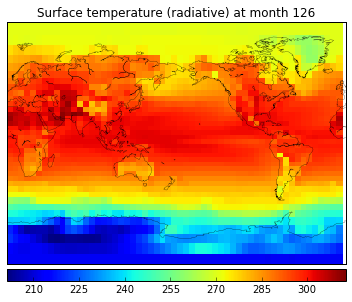

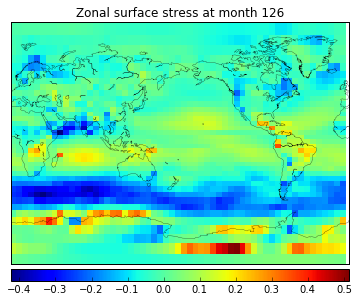

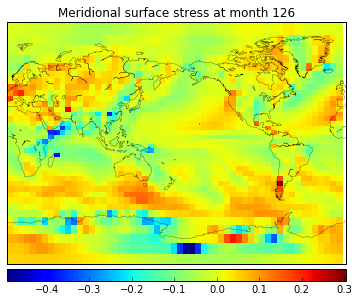

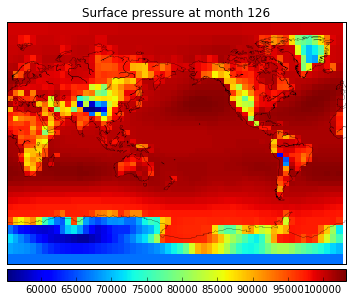

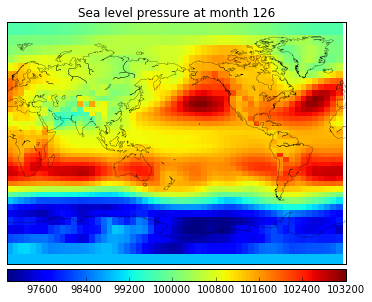

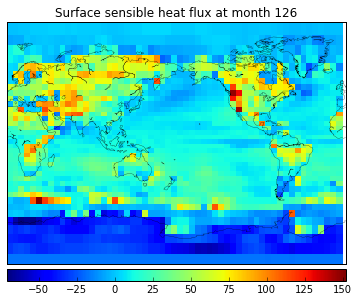

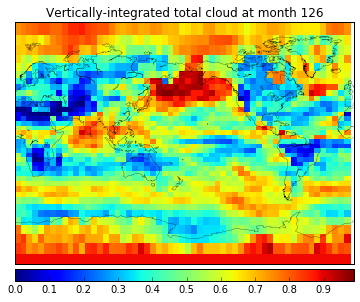

In [7]:
t = 126
plot_map(X_train_ds['ts'], t)
plot_map(X_train_ds['taux'], t)
plot_map(X_train_ds['tauy'], t)
plot_map(X_train_ds['ps'], t)
plot_map(X_train_ds['psl'], t)
plot_map(X_train_ds['shflx'], t)
plot_map(X_train_ds['cldtot'], t)

##The target.

The size of the Northern hemisphere sea ice area in million square kilometers, shifted by 4 months. Note that this variable is also part of the input (see above), shifted back so it is aligned with the other variables.

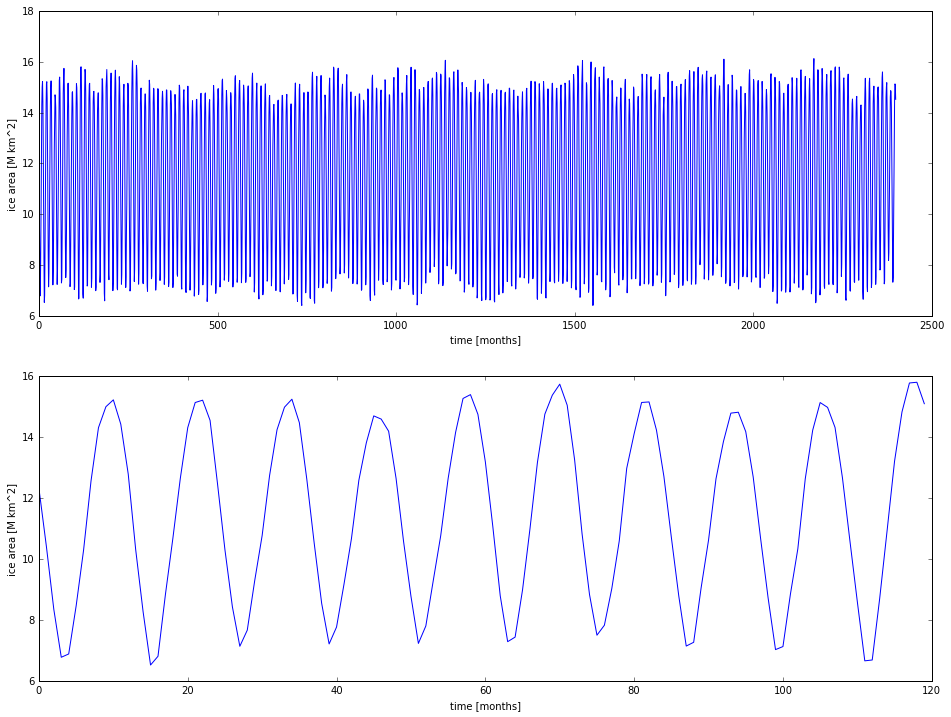

In [8]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(2, 1, 1)
ax.set_xlabel('time [months]')
ax.set_ylabel('ice area [M km^2]')
ax.plot(X_train_ds['time'], y_train_array)

ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('time [months]')
ax.set_ylabel('ice area [M km^2]')
ax.plot(X_train_ds['time'][:120], y_train_array[:120])

You can index xarray.DataArrays similarly to  <code>pandas</code> dataframes or <code>numpy</code> array. The result is always a <coda>DataArray</code>

In [9]:
t = 123
lat = 13
lon = 29

In [10]:
X_train_ds['ice_area'][t]

<xarray.DataArray 'ice_area' ()>
array(15.104208946228027)
Coordinates:
    time     int64 123
Attributes:
    units: M km^2
    long_name: Northern hemisphere sea ice area

In [11]:
X_train_ds['ts'][t, lat]

<xarray.DataArray 'ts' (lon: 58)>
array([ 295.59591675,  295.07791138,  294.45925903,  294.78408813,
        288.77880859,  291.56396484,  298.48806763,  297.63412476,
        297.5552063 ,  297.53845215,  296.98577881,  296.33615112,
        295.85488892,  295.92886353,  295.80258179,  295.87490845,
        295.74572754,  295.77178955,  296.7930603 ,  292.07907104,
        291.61053467,  292.21737671,  293.14453125,  293.36508179,
        291.76367188,  297.66732788,  296.72033691,  296.54873657,
        296.52822876,  296.44299316,  296.6003418 ,  296.62612915,
        296.82583618,  296.63656616,  296.60079956,  296.29983521,
        296.13354492,  296.13833618,  296.25424194,  296.24615479,
        296.20727539,  296.2722168 ,  296.06176758,  295.63986206,
        294.83700562,  293.28112793,  292.99810791,  291.66906738,
        295.5954895 ,  293.546875  ,  298.87069702,  298.63113403,
        298.16497803,  297.65112305,  297.69174194,  297.3137207 ,
        296.68838501,  296.0

You can convert any of these objects into a <code>numpy</code> array.

In [12]:
X_train_ds['taux'].values

array([[[ 0.0119357 ,  0.00967538,  0.00755875, ...,  0.01186193,
          0.01094299,  0.01223385],
        [ 0.04418786,  0.03387049,  0.03168348, ...,  0.06339279,
          0.05515647,  0.04856688],
        [ 0.01487134,  0.00971392,  0.0040994 , ...,  0.01949723,
          0.02168174,  0.01505342],
        ..., 
        [ 0.10183746,  0.14757751,  0.15264253, ..., -0.07095214,
          0.00252996,  0.05996004],
        [ 0.05678723,  0.07036243,  0.0788954 , ...,  0.0017223 ,
          0.02385753,  0.04718025],
        [ 0.07662992,  0.07686044,  0.07695989, ...,  0.07204499,
          0.07486361,  0.07623435]],

       [[ 0.01011548,  0.0075349 ,  0.00528584, ...,  0.01245966,
          0.01104006,  0.01090384],
        [ 0.02703727,  0.01821393,  0.0179223 , ...,  0.05918412,
          0.04455166,  0.03356633],
        [ 0.00456722, -0.00230912, -0.00904264, ...,  0.02786676,
          0.01729668,  0.00657242],
        ..., 
        [ 0.00528127,  0.04602627,  0.06414331, ...,

You can also use slices, and slice bounds don't even have to be in the index arrays.

In [13]:
X_train_ds['tauy'][12].loc[10:50]

<xarray.DataArray 'tauy' (lat: 8, lon: 58)>
array([[  4.97682430e-02,   4.68425900e-02,   9.57588479e-02,
          6.52332753e-02,   1.11731589e-01,   1.32701740e-01,
         -8.42545927e-02,  -3.62382755e-02,   6.08293600e-02,
          9.82054621e-02,   7.53740743e-02,   3.35314944e-02,
          1.13893338e-02,   3.22436169e-02,   2.13490445e-02,
          1.79915167e-02,   8.18525255e-02,   1.57157019e-01,
          1.32277206e-01,   9.24332142e-02,   3.08396369e-01,
          6.20350651e-02,   6.16410971e-02,   6.16705529e-02,
          5.34010641e-02,   5.05626611e-02,   5.51857054e-02,
          5.30319251e-02,   4.82309870e-02,   4.32035588e-02,
          3.70628797e-02,   3.47463414e-02,   3.07956636e-02,
          2.79106926e-02,   1.66940093e-02,   1.13737546e-02,
          1.22579951e-02,   1.28372032e-02,   1.43168503e-02,
          1.15823392e-02,   6.22215401e-03,   6.15868764e-03,
          1.44075751e-01,   1.15760475e-01,   1.98909521e-01,
          3.61324400e-02, 

In [14]:
X_train_ds.isel(time=t)

<xarray.Dataset>
Dimensions:   (lat: 39, lon: 58)
Coordinates:
    time      int64 123
  * lat       (lat) float64 -90.0 -85.29 -80.58 -75.86 -71.15 -66.44 -61.73 ...
  * lon       (lon) float64 0.0 6.25 12.5 18.75 25.0 31.25 37.5 43.75 50.0 ...
Data variables:
    ice_area  float64 15.1
    ts        (lat, lon) float32 221.286 221.266 221.285 221.287 221.273 ...
    taux      (lat, lon) float32 0.0259886 0.0205801 0.0151063 0.00936647 ...
    tauy      (lat, lon) float32 0.0475492 0.0497843 0.0520096 0.0533593 ...
    ps        (lat, lon) float32 68001.4 68001.4 68001.4 68001.4 68001.4 ...
    psl       (lat, lon) float32 100270.0 100270.0 100270.0 100270.0 ...
    shflx     (lat, lon) float32 -18.782 -18.8291 -18.7908 -18.7875 -18.8209 ...
    cldtot    (lat, lon) float32 0.769741 0.769741 0.769741 0.769741 ...
Attributes:
    n_burn_in: 120
    n_lookahead: 4

## The cross-validation object

Cross validating time-series predictors is tricky. We can't simply shuffle the observations $z_t =$ <code>X_train_ds.isel(time=t)</code> since we would lose both causality and the correlation structure that follows natural order. 

To formalize the issue, let us first define formally the predictor that we will produce in the RAMP. Let the time series be $z_1, \ldots, z_T$ and the let target to predict at time $t$ be $y_t$. The target is usually (and in our case) a function of the future $z_{t+1}, \ldots$, but it can be anything else. We want to learn a function that predicts $y$ from the past, that is

\begin{equation}
\hat{y}_t = f(z_1, ..., z_t) = f(Z_t)
\end{equation}

where $Z_t = (z_1, ..., z_t)$ is the past. Now, the sample $(Z_t, y_t)$ is a regular (although none iid) sample from the point of view of shuffling, so we can train on $\{Z_t, y_t\}_{t \in \cal{I}_{\text{train}}}$ and test on $(Z_t, y_t)_{t \in \cal{I}_{\text{test}}}$, where $\cal{I}_{\text{train}}$ and $\cal{I}_{\text{test}}$ are arbitrary but disjunct train and test index sets, respectively (typically produced by sklearn's <code>ShuffleSplit</code>). Using shuffling would nevertheless allow a second order leakage from training points to test points that preceed them, by, e.g., aggregating the training set and adding the aggregate back as a feature. To avoid this, we use block-CV: on each fold, all $t \in \cal{I}_{\text{test}}$ is larger than all $t \in \cal{I}_{\text{train}}$. We also make sure that all training and test sets contain consecutive observations, so recurrent nets and similar predictors, which rely on this, may be trained.

The training algorithm thus maps $(Z_t, y_t)_{t \in \cal{I}_{\text{train}}}$ to $f$. The point $Z_t$ contains the target for all training points $Z_{t'}$ for $t' \le t -4$, so it is technically possible to cheat: when you receive a tes set $z_1, ..., z_T$, you could look up the target of $z_t$ in $z_{t+4}$. To detect this (often inadvertant) cheating, we will check that you feature extractor is invariant to the future. 

To allow a reasonably long past before making the first prediction, we strip the first $b = 120$ months (burn-in). You can of course use a longer window in your feature extractor, but in this case you will have to handle the missing time points in the beginning of the sequence.

## The pipeline

We have factorized the pipeline into two steps. The first feature extractor $g$ transforms the past into a classical feature vector $x_t = g(Z_t)$, and the classical regressor $h$ predicts the target from the feature vector $\hat{y}_t = h(x_t)$. To summarize, the full predictor is a composition $f(Z_t) = h(g(Z_t))$. If you have a complex solution where this factorization does not make sense, you can do all the work in the feature extractor, output a prediction $x_t$ into a single-column feature matrix, and then use an identity regressor $\hat{y}_t = x_t$ in the regressor module. 

### The feature extractor

The feature extractor implements a single <code>transform</code> function. As we explained above, it receives the full <code>X_ds</code> and the length of the burn-in period $b$. It should produce a feature matrix of length $T - b$, type numpy array, representing the past vector $(Z_{t+b}, \ldots, Z_{T})$. For constructing/computing $x_t$, it can only use the past $Z_t = (z_1, \ldots, z_t) = $ <code>X_train_ds.isel(time=slice(None, t))</code>.

You can choose one of the example feature extractors and copy-paste it into your ts_feature_extractor.py file. Comments within the cells explain what they do. 

In [15]:
import numpy as np
import xarray as xr


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the vector of input variables at time t. Spatial variables will
        be averaged along lat and lon coordinates."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = np.arange(X_ds.attrs['n_burn_in'], len(X_ds['time']))
        # We convert the Dataset into a 4D DataArray
        X_xr = X_ds.to_array()
        # We compute the mean over the lat and lon axes
        mean_xr = np.mean(X_xr, axis=(2, 3))
        # We convert it into numpy array, transpose, and slice the valid range
        X_array = mean_xr.values.T[valid_range]
        return X_array

In [16]:
import numpy as np
import xarray as xr


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the vector of input variables at time t. Spatial variables will
        be concatenated."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = np.arange(X_ds.attrs['n_burn_in'], len(X_ds['time']))
        # We convert the Dataset into a 4D DataArray
        X_xr = X_ds.to_array()
        # We convert it into np array, put the t axis first
        X_array_t_first = np.swapaxes(X_xr.values, 0, 1)
        shape = X_array_t_first.shape
        # We reshape it to create one vector per time step, and slice the valid range
        X_array = X_array_t_first.reshape(shape[0], shape[1] * shape[2] * shape[3])[valid_range]
        return X_array

In [17]:
import numpy as np
import xarray as xr


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the vector of input variables at time [t, t-1, ... t-window_size+1] then 
        concatenate. Spatial variables will be averaged along lat and lon coordinates"""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = np.arange(X_ds.attrs['n_burn_in'], len(X_ds['time']))
        # We convert the Dataset into a 4D DataArray
        X_xr = X_ds.to_array()
        # We compute the mean over the lat and lon axes
        mean_xr = np.mean(X_xr, axis=(2, 3))
        mean_array_transposed = mean_xr.values.T
        window_size = 10
        #We concatenate the past window_size means
        mean_array_c = np.concatenate(
            [np.roll(mean_array_transposed, i) for i in range(window_size)], axis = 1)
        # We slice the valid range
        X_array = mean_array_transposed[valid_range]
        return X_array

In [80]:
import numpy as np
import xarray as xr


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the monthly averages of the ice_area, corresponding to the month to predict.
        The code could be simplified but in this way it is general, can be used for the other 
        variables as well."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = np.arange(X_ds.attrs['n_burn_in'], len(X_ds['time']))
        # We convert the Dataset into a 4D DataArray
        X_xr = X_ds.to_array()
        # We compute the mean over the lat and lon axes
        mean_array = np.mean(X_xr, axis=(2, 3)).values
        # We group the 8 monthly series into 8 x 12 monthly groups of series
        monthly_groups = mean_array.reshape((mean_array.shape[0], 12, -1), order='F')
        # We compute cumulative means in each group
        monthly_means = np.cumsum(monthly_groups, axis=2) / (1. + np.arange(monthly_groups.shape[2]))
        # We repeat each mean 12 times
        monthly_means_per_month = np.repeat(monthly_means, 12, axis=2)
        # We pad m 0s to the series corresponding to month m, no single-line operation for this
        for j in range(monthly_means_per_month.shape[0]):
            for m in range(12):
                monthly_means_per_month[j, m] = np.roll(monthly_means_per_month[j, m], m)
                monthly_means_per_month[j, m, :m] = 0
        # We reshape and transpose it into one vector per month
        monthly_ice_area_mean = monthly_means_per_month[0]
        # At each month t we use the running mean correponting to month t - 8
        X_array = np.array(
            [monthly_ice_area_mean[(t - 9) % 12][t] for t in range(monthly_ice_area_mean.shape[1])])
        # We slice the valid range
        X_array = X_array[valid_range].reshape(-1, 1)
        return X_array

In [102]:
mean_array = np.cov(X_xr)

ValueError: shapes (8,3600,39,58) and (58,39,3600,8) not aligned: 58 (dim 3) != 3600 (dim 2)

The following feature extractor "cheats": it rolls the feature array backwards, making the future part of the features. Check what happens when the unit test is run.

In [87]:
X_xr = X_ds.to_array()
        # We compute the mean over the lat and lon axes
mean_array = np.mean(X_xr, axis=(2, 3)).values

array([[  1.40561886e+01,   1.48676786e+01,   1.48415346e+01, ...,
          9.25084782e+00,   1.06853428e+01,   1.29467840e+01],
       [  2.75604196e+02,   2.74281470e+02,   2.74478928e+02, ...,
          2.75714894e+02,   2.74833915e+02,   2.74856848e+02],
       [ -6.72369226e-03,  -1.71711002e-02,  -1.64531989e-02, ...,
         -1.23599588e-02,  -1.05835738e-02,  -9.10951915e-03],
       ..., 
       [  1.00961797e+05,   1.00752154e+05,   1.00739509e+05, ...,
          1.00737537e+05,   1.00830226e+05,   1.00898329e+05],
       [  1.04204841e+01,   1.06889134e+01,   1.00212825e+01, ...,
          9.51422474e+00,   9.85376134e+00,   1.07601159e+01],
       [  4.43620334e-01,   4.42844821e-01,   4.45285106e-01, ...,
          4.51830032e-01,   4.40753547e-01,   4.40872835e-01]])

In [70]:
import numpy as np
import xarray as xr
from scipy import stats


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the vector of input variables at time t. Spatial variables will
        be averaged along lat and lon coordinates."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = np.arange(X_ds.attrs['n_burn_in'], len(X_ds['time']))
        # We convert the Dataset into a 4D DataArray
        X_xr = X_ds.to_array()
        # We compute the mean over the lat and lon axes
        np.mean_xr = stats.variation(X_xr, axis=(2, 3))
        # We convert it into numpy array, transpose, and slice the valid range
        # We roll it backwards to see what happens when the feature extractor
        # attempts to look into the future.
        X_array = mean_xr.values.T[np.roll(valid_range, -2)]
        return X_array

In [79]:
X_xr = X_ds.to_array()
        # We compute the mean over the lat and lon axes
mean_xr = stats.variation(X_xr, axis=(2, 3))


SyntaxError: invalid syntax (<ipython-input-79-c2ccdf6a7954>, line 4)

In [78]:
np.mean_xr

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.93366971e-02,   8.84467943e-02,   9.08866432e-02, ...,
          8.65274712e-02,   8.48128632e-02,   8.27479334e-02],
       [ -1.59647638e+01,  -5.77631641e+00,  -6.26483486e+00, ...,
         -8.63033674e+00,  -9.96263144e+00,  -1.09193055e+01],
       ..., 
       [  1.20301261e-02,   1.26079350e-02,   1.19267906e-02, ...,
          1.28625358e-02,   1.30974632e-02,   1.17459051e-02],
       [  2.81952348e+00,   2.68140244e+00,   2.63921615e+00, ...,
          2.50306614e+00,   2.47299112e+00,   2.57474948e+00],
       [  4.35753962e-01,   4.09116803e-01,   3.56972931e-01, ...,
          3.58824771e-01,   3.99270191e-01,   4.22347102e-01]])

### The regressor

The regressor should implement an sklearn-like regressor with fit and predict functions. Let's start with two simple regressors, a linear regressor and a random forest. You can copy paste either of these into your first regressor.py file.

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = LinearRegression()

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestRegressor(n_estimators=10, max_leaf_nodes=10)

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

In [40]:
pd.set_option('display.max_rows', 640)
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
importance = pd.DataFrame({'feature':cols, 'importance':treereg.feature_importances_})

NameError: name 'numeric' is not defined

In [38]:
clf = RandomForestRegressor(n_estimators=10, max_leaf_nodes=10)
clf.fit(X_train_ds,y_train_array)

ValueError: could not convert string to float: ice_area

In [34]:
pd.set_option('display.max_rows', 640)
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
importance = pd.DataFrame({'feature':X_ds, 'importance':clf.feature_importances_})

NotFittedError: Estimator not fitted, call `fit` before `feature_importances_`.

### Unit test

You should use this notebook for preliminary analysis and visualization. Before submitting, you should make sure the code has no errors. First, copy-paste your regressor and feature extractor into the files <code>regressor.py</code> and <code>ts_feature_extractor.py</code>. Then exacute the user_test_submission code, either in a separate terminal or below. You can also look at <code>user_test_submission.py</code> to see how we cross-validate and score your submissions. But don't modify it: its goal is to mimic what we do at our backend.

In [152]:
!python user_test_submission.py

length of training array: 2304 months = 192 years
length of test array: 1296 months = 108 years
length of burn in: 120 months = 10 years
length of common block: 1032 months = 86 years
length of validation block: 1152 months = 96 years
length of each cv block: 144 months = 12 years
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is depreca

In [140]:
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import BayesianRidge, LinearRegression
br = BayesianRidge(compute_score=True)
clf = RandomForestRegressor()
pipeline = Pipeline([
    ('vect', DecisionTreeRegressor()),
    ('tfidf', RandomForestRegressor()),
    ('clf', LinearRegression()),
])
